# CarND-Advanced-Lane-Lines
This is my implementatoin of advanced lane finding to Udacity CarND project 4.

#Advanced Lane Finding Project

The goals / steps of this project are the following:

1-Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.<br />
2-Apply a distortion correction to raw images.<br />
3-Use color transforms, gradients, etc., to create a thresholded binary image.<br />
4-Apply a perspective transform to rectify binary image ("birds-eye view").<br />
5-Detect lane pixels and fit to find the lane boundary.<br />
6-Determine the curvature of the lane and vehicle position with respect to center.<br />
7-Warp the detected lane boundaries back onto the original image.<br />
8-Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.<br />
9- Apply all to the video


In [1]:
#Importing required Modules
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import cv2
import math
import pickle
import glob
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def corners_find(images):
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        # Converts to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Finds the chessboard corners
        ret, corners_cal = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, adds object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners_cal)
            cv2.drawChessboardCorners(img, (nx, ny), corners_cal, ret)
    return corners_cal

In [3]:
t_corners_start = time.time()

nx=9
ny=6 

images=glob.glob('camera_cal/calibration*.jpg')

# prepares object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
corners=corners_find(images)
print('Finding Corneres --> Done')
t_corners_stop = time.time()
print('It took: ' + str(round((t_corners_stop - t_corners_start),2)) + ' seconds.')

Finding Corneres --> Done
It took: 5.35 seconds.


In order to change perspective of an images, first we need to calibrate the combination camera and lens by the means of calculating the distortion coefficient.
To do so I dfined a function, conrners_find() to find the corners of sample chess board shot by the camera in question. Then I will use the data collected from this function to undistored images in the final video.

In [4]:
# Defining function to undistort camera reference images by extracting the distortion coefficient.
def img_undist(img, objpoints, imgpoints,corners):
    # cv2.calibrateCamera and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1] ,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist,ret,mtx,dist,rvecs, tvecs

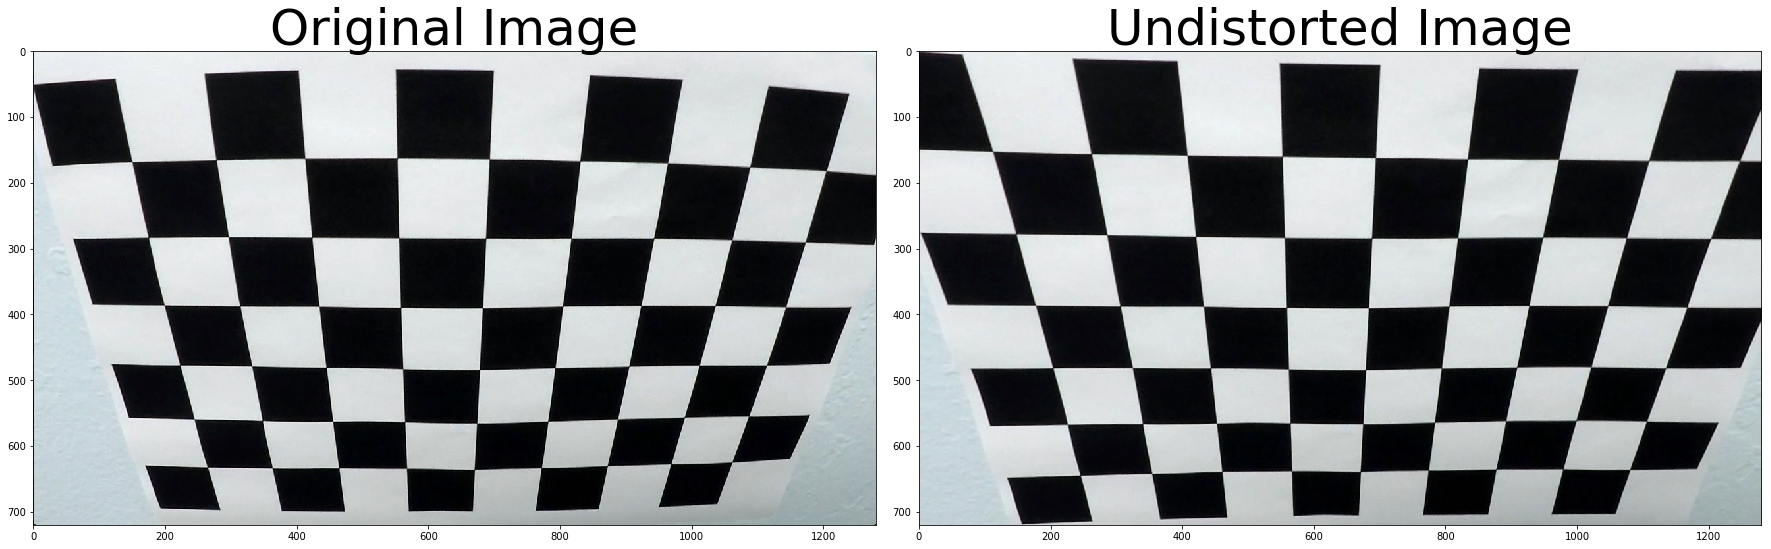

In [5]:
# Implementing distortion control on a sample image.
img = cv2.imread('camera_cal/calibration2.jpg')
undistorted, ret, mtx, dist, rvecs, tvecs = img_undist(img, objpoints, imgpoints,corners)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


And following is inplementation of calibration and distortion on one of the sample images. From the buttom edge of the image it is obvious that the function was able to undistort the photo. 

With looking at this photo I noticed an issue with the undistorted image. In this specific example the bonnet of the car is almost disappearing from the image. 

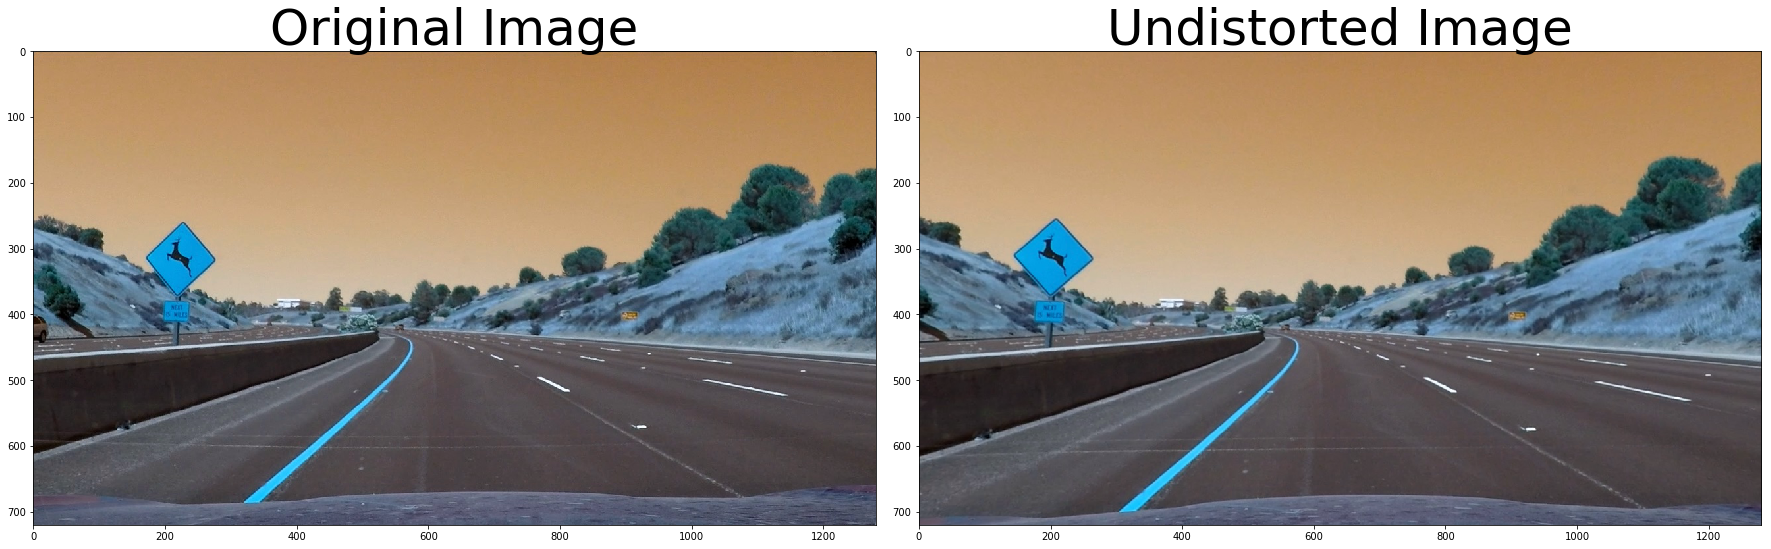

In [6]:
img = cv2.imread('test_images/test2.jpg')
undistorted,ret, mtx, dist, rvecs, tvecs = img_undist(img, objpoints, imgpoints,corners)

mpimg.imsave('output_images/test2_undist.jpg',img, format = 'jpg')

f_sample, (ax1_sample, ax2_smple) = plt.subplots(1, 2, figsize=(24, 9))
f_sample.tight_layout()
ax1_sample.imshow(img)
ax1_sample.set_title('Original Image', fontsize=50)
ax2_smple.imshow(undistorted)
ax2_smple.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Next step is to model the curvature with interpolation. But first we need to change perspective of the image to be able to apply interpolation.

In the following cell I will aplly sobel operator on X direction to detect near vertical lines which are more likely to be lane lines. First I defined combine_binary() function where it calculates derivative in X direction. Then I continue with calculating absolute value of the derivatives. Then I repeat the same procedure in Y direction. In both derivatives I only kept the values between minimum and maximum thresholds (70 and 100 respectively). 

Then I repeated same procedure for s_channel of HLS and R_channel. Again I only saved values between minimum and maximum threshold (160/200 and 220/240 respectively.)

Then I combine the output of all for derivatives and filter out everything except those derivative values that are equal to 1.

In [7]:
def combine_binary(img):
    
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 70
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # Threshold y gradient
    thresh_min = 70
    thresh_max = 100
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_thresh_min = 160
    s_thresh_max = 200
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    #Separate the R channel
    
    R_channel = img[:,:,0]
    # Threshold color channel
    R_thresh_min = 220
    R_thresh_max = 240
    R_binary = np.zeros_like(s_channel)
    R_binary[(R_channel >= R_thresh_min) & (R_channel <= R_thresh_max)] = 1
    # Combine the three binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)|(R_binary == 1)| (sybinary == 1)] = 1
    return combined_binary

In the next cell I apply the combine_binary() function to a sample image.

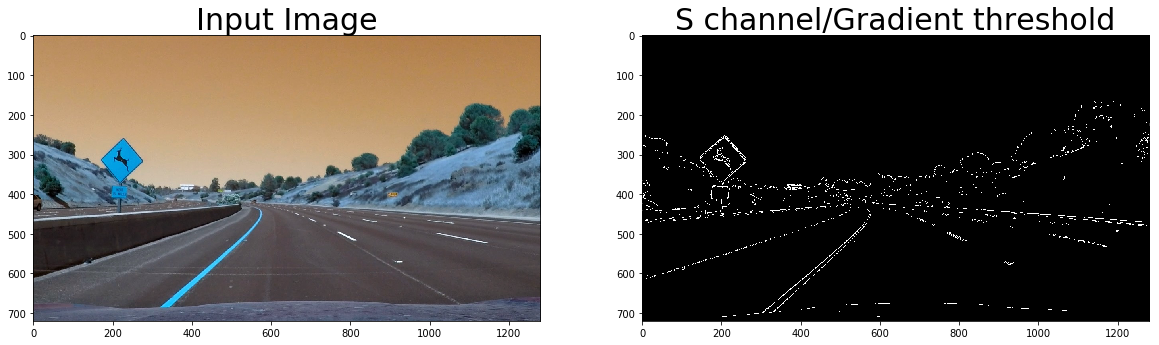

In [8]:
combined_binary=combine_binary(undistorted)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Input Image',fontsize=30)
ax1.imshow(img, cmap='gray')
ax2.set_title('S channel/Gradient threshold',fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
mpimg.imsave('output_images/test2_combined_binary.jpg',combined_binary, format = 'jpg')

Next I defined corners_unwarp() function to get the birds eyeview of the lane. To do so first I generate the info required for perspective transform using the cv2.getPerspectiveTransform() in form of a matrix. hen I applied the transform matrix to produce a warped image using the cv2.warpPerspective(). I also calculated the inverse of the conversion matrix by switching the input and output points that later will be used to transform drawn lines to camera perspective.

In [9]:
def corners_unwarp(img, mtx, dist,src,dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(np.float32(src), dst)
    warped = cv2.warpPerspective(img, M, img_size)
    inv_M = cv2.getPerspectiveTransform(dst,np.float32(src))
    return warped, M,inv_M

In [10]:
# Finding size of the image
ysize=img.shape[0]
xsize=img.shape[1]
#input points making a trapizoid on the image
left_bottom = [200, ysize]
right_bottom = [xsize-180, ysize]
left_top=[600,450]
right_top=[700,450]
vrio=(np.array([left_bottom,left_top,right_top,right_bottom]))
#output points making a trapizoid on the image
vmapped=np.float32([[255, ysize], [255, 0], 
                                     [1000, 0], 
                                     [1000, ysize]])
line_image = np.copy(undistorted)
points=vrio.reshape((-1,1,2))
line_image=cv2.polylines(line_image,[points],True,(200,20,60),8)
top_down, perspective_M,inv_M = corners_unwarp(line_image,mtx, dist,vrio,vmapped)

Following is a visualization of perspective transformation for an image. 

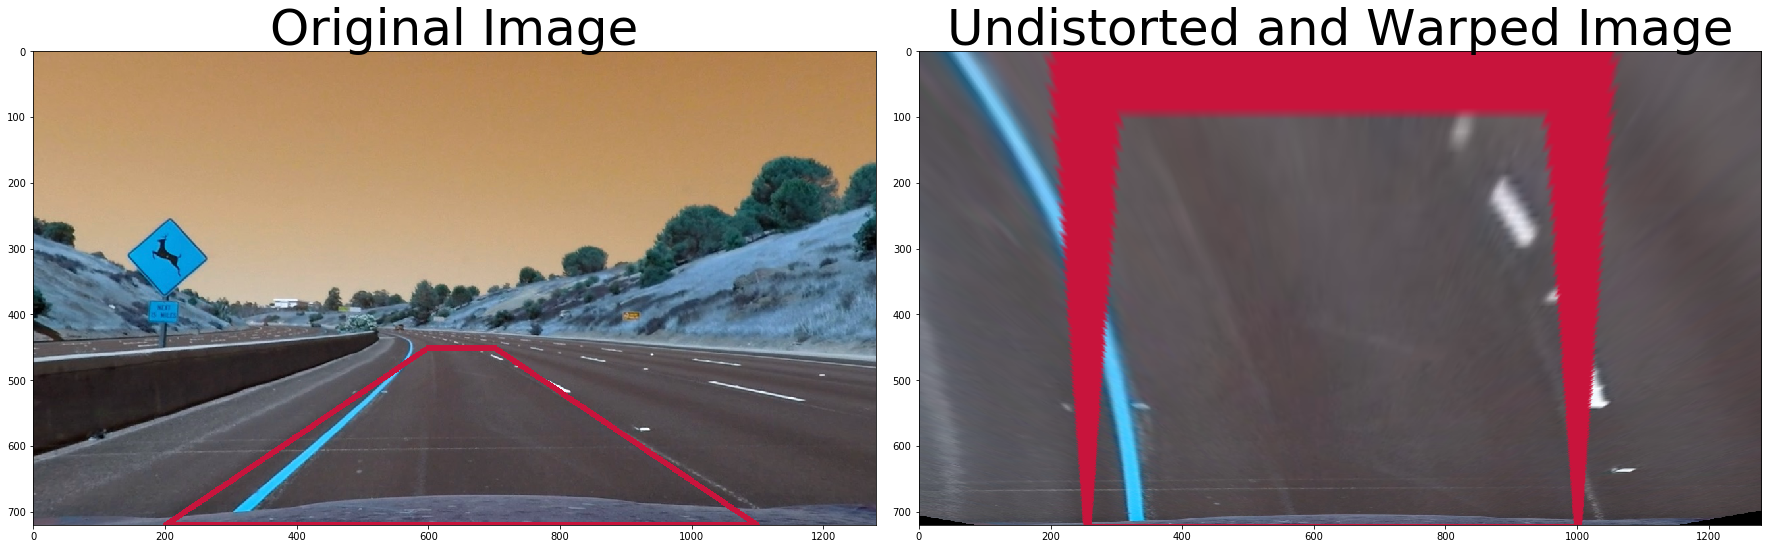

In [11]:

#Visulaize(1) 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(line_image,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


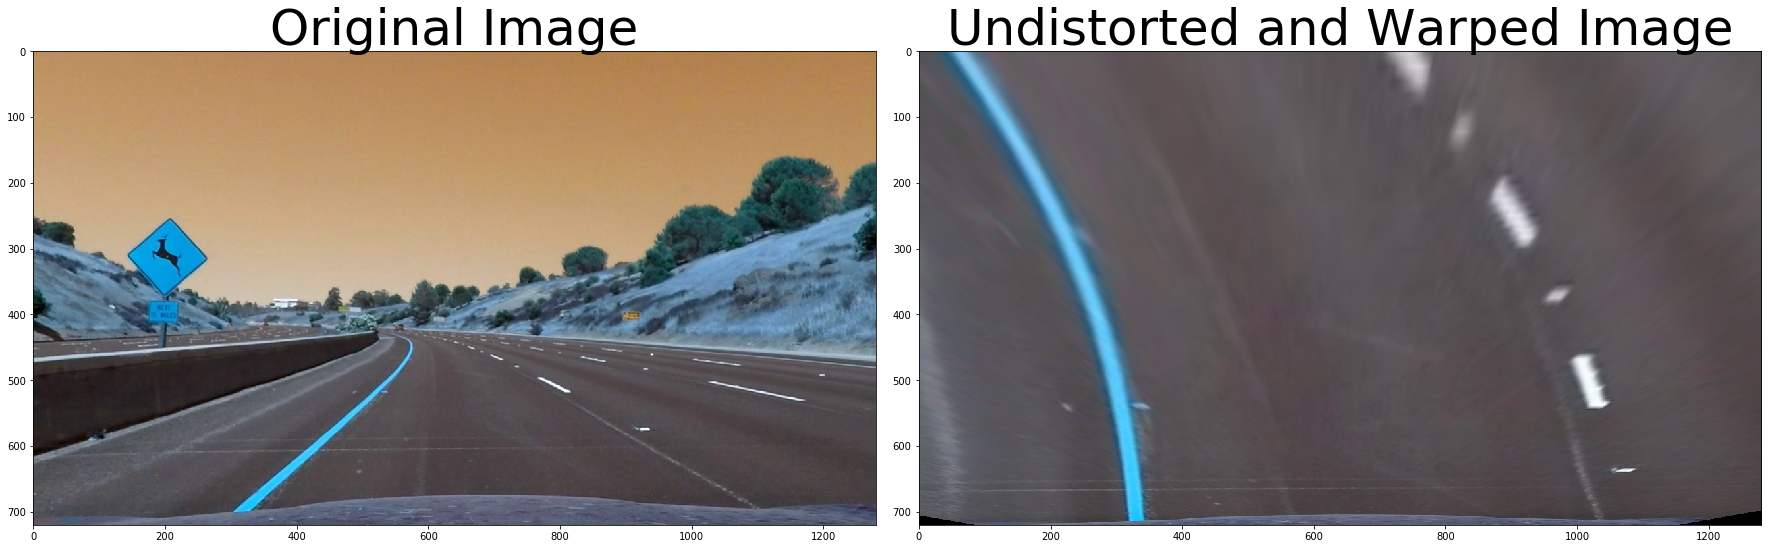

In [12]:
#Visulaize(2) 
top_down, perspective_M,inv_M = corners_unwarp(undistorted,mtx, dist,vrio,vmapped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave('output_images/test2_top_down.jpg',top_down, format = 'jpg')

Following is a visualiztion of transformed perspective with applying combined_binary() function

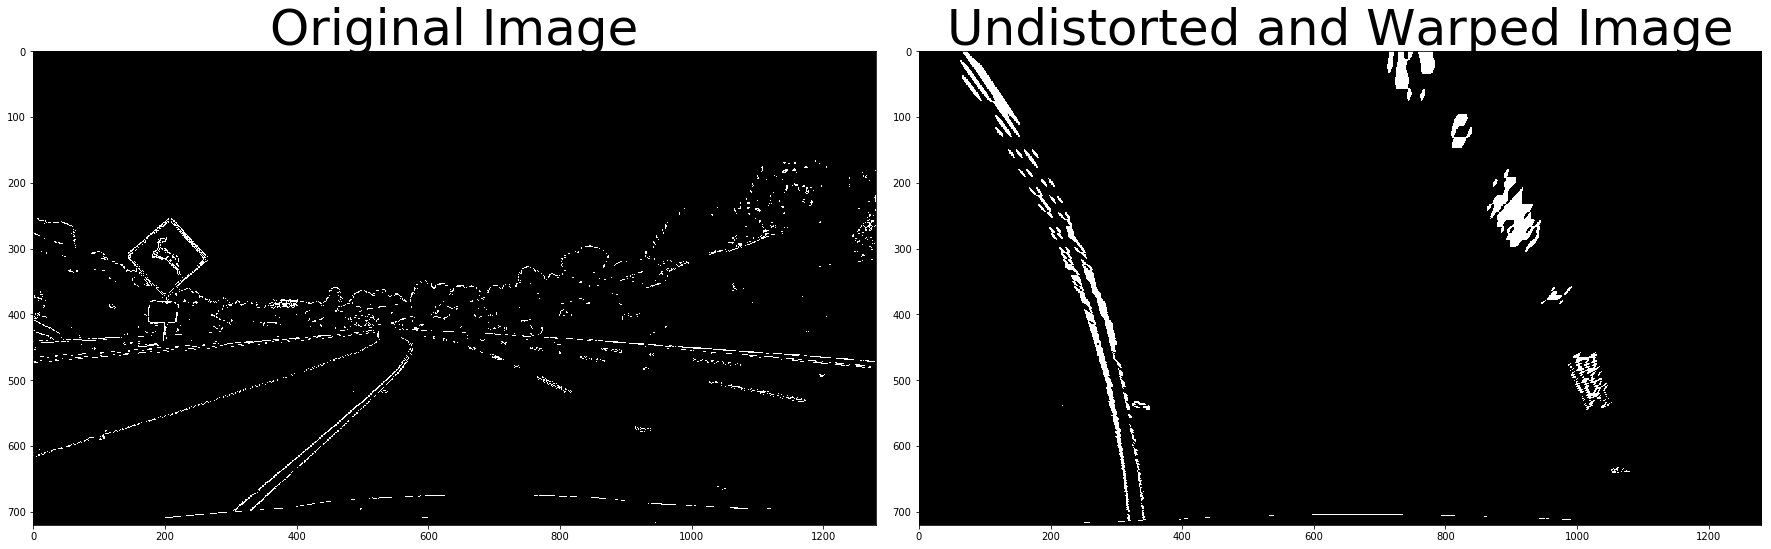

In [13]:
#Visulaize(3) 
top_down, perspective_M,inv_M = corners_unwarp(combined_binary,mtx, dist,vrio,vmapped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave('output_images/test2_combines_topdown.jpg',top_down, format = 'jpg')

Next step is to detect the line pixels in the perspective control image. 

To do so first I define a class that stores all values fitted for x and y cordiantes. At the end of this cell I initiate two instances for left and right lines.

In [14]:
class Line():
    def __init__(self):
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # y values of the last n fits of the line
        self.recent_yfitted = [] 

left_line=Line()
right_line=Line()

Next step is to find lanes and fit a polynomial to the pixels of lanes. To do so first we have to be able to finde the location of the lines in the image. To acheive this goal I defined a function, get_histmax() where is calculated the histogram of an image and returns maximum numbers in histogram using np.argmax() method. These numbers are indications of line cordinates.

In [15]:
def get_histmax(img):
    histogram = np.sum(img[:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    centerx_base=np.int((leftx_base+rightx_base)/2)
    return leftx_base,centerx_base,rightx_base

Now we can start to define a function to find pixels corresponding to each line and then fit a polynomial to each line. This is done by defining find_line() function.

First we find the location where each line starts by using the get_histmax() which returns all non-zero pixels in lower half of the input image. Again, the maximum of these histograms will be our starting points for left and right lines.

With these info we can also verify if the vehicle is centered in the lanes or not by simply comparing the distance between left and right points with the center point recpectively.

I chose 18 windows in the y-direction centered them on the starting point of each line. After trying different numbers for window width, I chose 200 pixels wide left and 160 pixels wide right windows.

Then I separated all non-zero elements of the output list and convereted them to arrays. I continue with comapring the number of non-zero pixels with a threshold of 50 pixels. If non-zero pixels supass the threshold, I use them as my new starting point and add them to my list of found points. If not I continue searching with my last found non-zero pixels. I found that 50 pixels of threshold is a good safety net for ignoring noise and unwanted points in the image. 

After locating and verifying non-zero pixels, I fit a second order polynomial to each line (left and right) and at the end I store all lines and visualize them in the final output image.

In [16]:
def find_line(binary_warped,vis=True):
    # Take a histogram of the bottom half of the image
    leftx_base,centerx_base,rightx_base = get_histmax(binary_warped[binary_warped.shape[0]//2:,:])
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines

    
    left_dist=(centerx_base-leftx_base)*3.7/700
    right_dist=(rightx_base-centerx_base)*3.7/700

    if left_dist>right_dist:
        center_text='Vehicle is {:.2f} m right centered'.format(abs((3.7/2)-right_dist))
    elif left_dist<right_dist:
        center_text='Vehicle is {:.2f} m left centered'.format(abs((3.7/2)-left_dist))
    else:
        center_text='Vehicle is centered'
    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    left_margin = 100
    right_margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - left_margin
        win_xleft_high = leftx_current + left_margin
        win_xright_low = rightx_current - right_margin
        win_xright_high = rightx_current + right_margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    left_line.recent_xfitted.append(left_fitx) 
    left_line.recent_yfitted.append(ploty)
    
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    right_line.recent_xfitted.append(right_fitx)
    right_line.recent_yfitted.append(ploty)
    if vis==True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    leftx_avg=np.average(left_line.recent_xfitted[-15:],axis=0)
    rightx_avg=np.average(right_line.recent_xfitted[-15:],axis=0)
    return leftx_avg,rightx_avg,ploty,center_text

A Visualaization of find_line() function as described above.

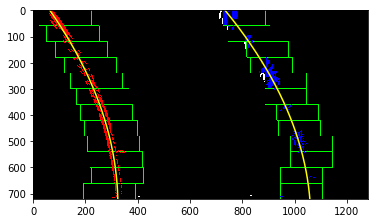

In [17]:
left_fit_x,right_fit_x,plot_y,center_text = find_line(top_down,vis=True)
#mpimg.imsave('output_images/test2_combines_find_line.jpg',find_line_img, format = 'jpg')

Now that we found left and right lines on transformed images, we can calculate the curvature from the fitted second order polynomials.

Next step is to find the curvature of each line and plot them on the screen.

To do so I defined a function called find_curve() where is takes its inputs from find_line() and on the ouput provides the curvature readius in meters.

In [18]:
def find_curvature(left_fitx,right_fitx,ploty):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

An example of find_curve() implemenation:

In [19]:
left_curverad, right_curverad=find_curvature(left_fit_x,right_fit_x,plot_y)

print(left_curverad, 'm', right_curverad, 'm')

351.323195561 m 322.121135877 m


Now that we found lines and calculated the their curve radius, we need to visually mark them on each image (or in case of final video on each frame) with a text descrition of properties.

To visually mark lanes, we will get the outputs from img_undist() and corners_unwarp() functions to draw the boundary lines on a blank image, then using the inverse matrix data  generated by the corners_unwarp() function we can transform the newly drawn lines to camera's perspective. 

In [20]:
def final_image(binary_warped,ploty,left_fitx,right_fitx,inv_M,undistorted):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_M, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result

Visualizatoin fo final_img():

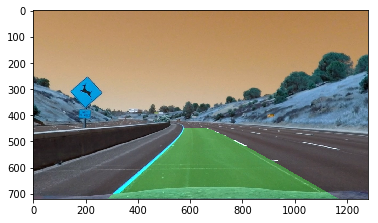

In [21]:
mapped=final_image(top_down,plot_y,left_fit_x,right_fit_x,inv_M,undistorted)
mpimg.imsave('output_images/test2_combines_mapped.jpg',mapped, format = 'jpg')

Next I defined a function to write the left and right line radii and if the vehicle is centered or not as verifed by find_line() function.

In [22]:
def write_text(img,text1,text2,text3):
    font = cv2.FONT_HERSHEY_PLAIN
    x='left curvetaure:{:.2f} m'.format(text1)
    y='right curvetaure:{:.2f} m'.format(text2)
    cv2.putText(img,x,(10,60), font, 2,(255,255,255),3)
    cv2.putText(img,y,(600,60), font, 2,(255,255,255),3)
    cv2.putText(img,text3,(10,120), font, 2,(255,255,255),3)
    return img

Visualization of write_text():

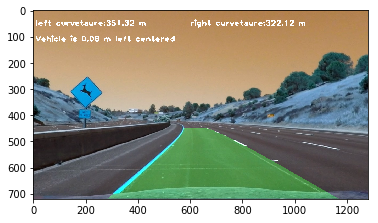

In [23]:
result=write_text(mapped,left_curverad, right_curverad,center_text)
plt.imshow(result)
mpimg.imsave('output_images/test2_result.jpg',result, format = 'jpg')

Until now all I did was to define functions and a class to process each image captured by the camera onboard the vehicle. Now it is time to implement it to the video feed.

For sake of simplicity and usability again I define a function for the pipeline where it takes each frame of the video feed as an input and conducted the process to finding lines and marking the lane in the image. All functions defined above are used here to complete the image processing pipeline.

In [24]:
def process_image(img):  
    undistorted,ret, mtx, dist, rvecs, tvecs = img_undist(img, objpoints, imgpoints,corners)
    combined_binary=combine_binary(undistorted)
    top_down, perspective_M,inv_M = corners_unwarp(combined_binary,mtx, dist,vrio,vmapped)
    left_fitx,right_fitx,ploty,center_text=find_line(top_down,vis=False)
    left_curverad, right_curverad=find_curvature(left_fitx,right_fitx,ploty)
    mapped=final_image(top_down,ploty,left_fitx,right_fitx,inv_M,undistorted)
    result=write_text( mapped,left_curverad, right_curverad,center_text)
    return result

The process_frame() function processes each frame of the video feed. Next using the MoviePy library I will render the output video called output_advanced_lane_find.mp4.

[MoviePy] >>>> Building video advanced_lane_find_submit.mp4
[MoviePy] Writing video advanced_lane_find_submit.mp4


100%|█████████▉| 1260/1261 [15:01<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: advanced_lane_find_submit.mp4 

CPU times: user 26min 58s, sys: 9.36 s, total: 27min 7s
Wall time: 15min 2s


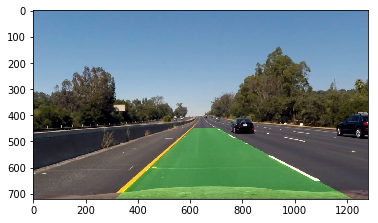

In [25]:
white_output = 'advanced_lane_find_submit.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)


There are few matters in this project that are good enough that I don't think they will need any extra altering like calibrating the camera and undistorting images. However, there are issues that need to be addressed. First the project video has clean sets of frames. The freeway lines are clearly visible, there are no extra lines in the freeway and the weather is clear. There is no rain, snow or sandstorms. Road imperfectoins can make the lane detection more difficult or maybe impossible. Weather conditions can also severly effect the output of the pipeline. Cameras always protected inside a closure, one way or another and usually there are glass windows infront of the camera lens. Dirt and debris can also significantly decrease the accuracy and effectiveness of the pipeline.

One solution I can think of to tackle the issue of unreliable video feed if using CNN to train a model over images to find lanes. Training a machine learning model, specifically a CNN will provide the benefit of vast volume of available data and possibility of data augmentation, considering with data augmentation it will be easier to model and traing for video feeds with lots of distractions and noise. I would like to spend more time on this option and find out if this is a good method to identify lines and vehicle position in a lane. I can think of a second advantage of this method that I will get to it at a later paragraph.

I tried to run this pipeline over the harder and there were issues with calculating the curvature. To slove this issue I would consider higher number of sliding windows. Again I have to try this option.

One last issue this pipeline has is the long time it takes to render the output video. In real world scenario this is not acceptable. Obviously there will be lees number of frames to process and make decision, but it will still be significantlly slow. This is where I think using CNN or machine learning models can be beneficial. Because with a well trained model, all the pipeline needs to do is to classify and make decision. However as I mentioned earlier this needs further study from my side.

One last issue I noticed in my final processed video is the jump in detected lane when the vehicle goes over the bridge initially. For few frames the detected lane 